# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from matplotlib.pylab import rcParams

In [2]:
df = pd.read_csv("zillow_data.csv")
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df['RegionName'].nunique()

14723

Regions of Colorado: 
1. 81521
2. 81524 
3. 81525 
4. 81507
5. 81505
6. 81501
7. 81401
8. 81301
9. 81321
10. 80206
11. 80011
12. 80303
13. 80301
14. 80302
15. 80903

In [4]:
colorado = pd.DataFrame()

In [5]:
zipcodes = [81521, 81524, 81525, 81507, 81505, 81501, 81401, 81301, 81321, 80206,
           80011, 80303, 80301, 80302, 80903]

In [6]:
colorado = df.loc[(df["RegionName"] == 81521) | (df["RegionName"] == 81520) | (df["RegionName"] == 81525) | 
                  (df["RegionName"] == 81507) | (df["RegionName"] == 81505) | (df["RegionName"] == 81501) | 
                  (df["RegionName"] == 81401) | (df["RegionName"] == 81301) | (df["RegionName"] == 81321) | 
                  (df["RegionName"] == 80206) | (df["RegionName"] == 80011) | (df["RegionName"] == 80303) | 
                  (df["RegionName"] == 80301) | (df["RegionName"] == 80302) | (df["RegionName"] == 80903)]

colorado

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1201,93201,80011,Aurora,CO,Denver,Arapahoe,1202,90400.0,90600.0,90900.0,...,269000,271900,274900,277500,280300,283700,286400,289300,293400,296400
2330,93283,80206,Denver,CO,Denver,Denver,2331,182300.0,183000.0,183900.0,...,725400,725300,726400,729700,733200,738700,744900,751900,759500,765600
2652,93757,81301,Durango,CO,Durango,La Plata,2653,153900.0,153100.0,152500.0,...,445400,449700,455000,456600,450300,453300,464200,463700,452500,449200
3225,93354,80302,Boulder,CO,Boulder,Boulder,3226,296600.0,295400.0,294100.0,...,874100,877900,881500,885800,888700,889400,890700,897100,908000,915100
3363,93355,80303,Boulder,CO,Boulder,Boulder,3364,231100.0,230300.0,229500.0,...,710400,708000,707300,711400,714700,715600,717300,724100,732800,737100
3382,93353,80301,Boulder,CO,Boulder,Boulder,3383,218000.0,217600.0,217200.0,...,645000,646800,648800,651000,653000,656400,660000,663600,668000,670700
4448,93799,81501,Grand Junction,CO,Grand Junction,Mesa,4449,74500.0,75100.0,75800.0,...,175600,176700,177600,178000,178800,179800,180500,182100,184700,186300
4503,93774,81401,Montrose,CO,Montrose,Montrose,4504,97800.0,97600.0,97200.0,...,214300,215800,217200,218000,218100,217100,216700,214700,209700,204800
6410,93581,80903,Colorado Springs,CO,Colorado Springs,El Paso,6411,87700.0,88100.0,88500.0,...,227800,230600,233400,236100,238300,240700,243500,246300,249300,251200
6485,93761,81321,Cortez,CO,NaN,Montezuma,6486,75200.0,75200.0,75100.0,...,174400,174500,173000,171200,170600,171500,172800,172800,172600,172900


In [7]:
colorado.drop('RegionID', axis = 1, inplace = True)

C:\Users\kayce_000\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [8]:
colorado.drop('SizeRank', axis = 1, inplace = True)

In [9]:
aurora = colorado.loc[colorado["RegionName"] == 80011]
denver = colorado.loc[colorado["RegionName"] == 80206]
durango = colorado.loc[colorado["RegionName"] == 81301]
boulder_1 = colorado.loc[colorado["RegionName"] == 80301]
boulder_2 = colorado.loc[colorado["RegionName"] == 80302]
boulder_3 = colorado.loc[colorado["RegionName"] == 80303]
grand_junction_1 = colorado.loc[colorado["RegionName"] == 81501]
montrose = colorado.loc[colorado["RegionName"] == 81401]
colorado_springs = colorado.loc[colorado["RegionName"] == 80903]
cortez = colorado.loc[colorado["RegionName"] == 81321]
grand_junction_2 = colorado.loc[colorado["RegionName"] == 81507]
fruita = colorado.loc[colorado["RegionName"] == 81521]
clifton = colorado.loc[colorado["RegionName"] == 81520]
grand_junction_3 = colorado.loc[colorado["RegionName"] == 81505]

In [10]:
aurora

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1201,80011,Aurora,CO,Denver,Arapahoe,90400.0,90600.0,90900.0,91100.0,91500.0,...,269000,271900,274900,277500,280300,283700,286400,289300,293400,296400


# Step 2: Data Preprocessing

In [11]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [12]:
get_datetimes(aurora)
get_datetimes(denver)
get_datetimes(durango)
get_datetimes(boulder_1)
get_datetimes(boulder_2)
get_datetimes(boulder_3)
get_datetimes(grand_junction_1)
get_datetimes(montrose)
get_datetimes(colorado_springs)
get_datetimes(cortez)
get_datetimes(grand_junction_2)
get_datetimes(fruita)
get_datetimes(clifton)
get_datetimes(grand_junction_3)
get_datetimes(colorado)

DatetimeIndex(['1996-06-01', '1996-07-01', '1996-08-01', '1996-09-01',
               '1996-10-01', '1996-11-01', '1996-12-01', '1997-01-01',
               '1997-02-01', '1997-03-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=263, freq=None)

# Step 4: Reshape from Wide to Long Format

In [13]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [14]:
melted_aurora = melt_data(aurora)
melted_denver = melt_data(denver)
melted_durango = melt_data(durango)
melted_boulder_1 = melt_data(boulder_1)
melted_boulder_2 = melt_data(boulder_2)
melted_boulder_3 = melt_data(boulder_3)
melted_grand_junction_1 = melt_data(grand_junction_1)
melted_montrose = melt_data(montrose)
melted_colorado_springs = melt_data(colorado_springs)
melted_cortez = melt_data(cortez)
melted_grand_junction_2 = melt_data(grand_junction_2)
melted_fruita = melt_data(fruita)
melted_clifton = melt_data(clifton)
melted_grand_junction_3 = melt_data(grand_junction_3)

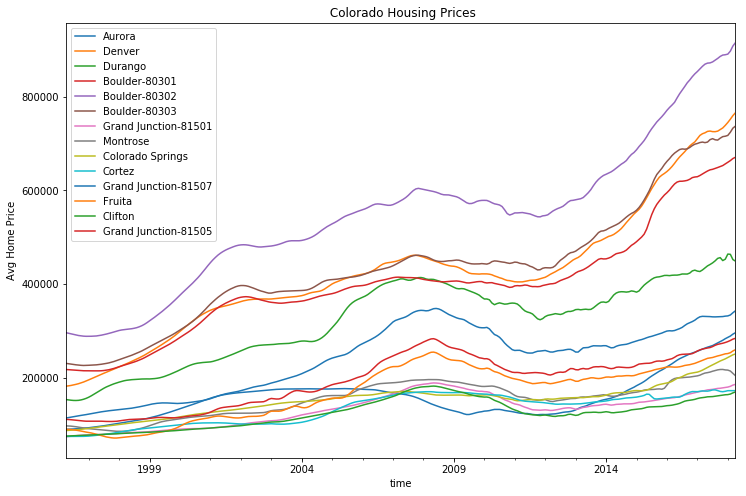

In [15]:

ax = melted_aurora.plot(figsize = (12, 8))
plt.title(" Colorado Housing Prices")
plt.xlabel("Year")
plt.ylabel("Avg Home Price")

melted_denver.plot(ax = ax)
melted_durango.plot(ax = ax)
melted_boulder_1.plot(ax = ax)
melted_boulder_2.plot(ax = ax)
melted_boulder_3.plot(ax = ax)
melted_grand_junction_1.plot(ax = ax)
melted_montrose.plot(ax = ax)
melted_colorado_springs.plot(ax = ax)
melted_cortez.plot(ax = ax)
melted_grand_junction_2.plot(ax = ax)
melted_fruita.plot(ax = ax)
melted_clifton.plot(ax = ax)
melted_grand_junction_3.plot(ax = ax)

ax.legend(["Aurora", "Denver", "Durango", "Boulder-80301", "Boulder-80302",
          "Boulder-80303", "Grand Junction-81501", "Montrose", "Colorado Springs",
          "Cortez", "Grand Junction-81507", "Fruita", "Clifton", "Grand Junction-81505"])

# Step 5: ARIMA Modeling

# Run ARIMA predictions, determine proper order 

In [1]:
def arima(data, arima_order):
    '''
    Function to calculate mean squared error using ARIMA 
    
    args: 
        data: pandas dataframe 
        arima_order: values desired for p, d, q
    returns: 
        (int): Mean Squared Error using data and given p, d, q values
    '''
    train_size = int(len(data)*.66)
    train, test = data.values[0:train_size], data.values[train_size:]
    history = [x for x in train]
    predictions = []
    for x in range(len(test)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit(disp = 0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[x])
    error = mean_squared_error(test, predictions)
    return error

In [2]:
#run ARIMA order code
def arima_order(dataset, p_values, d_values, q_values):
    '''
    A function to determine optimal p, d, q values 
    
    args: 
        dataset: a Pandas dataframe
        p_values: a range of values for p
        d_values: a range of values for d
        q_values: a range of values for q
    returns:
        best_cfg: combination of p, d, q values with lowest mean squared error
        best_score: lowest mean squared error
    '''
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = arima(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except: 
                    continue
        print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    

In [18]:
p_values = [0,1,2,4,6,8,10]
d_values = range(0,3)
q_values = range(0,3)

In [3]:
def arima_predictions(data, arima_order):
    '''
    A function to make predictions on given data
    
    args:
        data: a given Pandas dataframe
        arima_order: desired values of p, d, and q
    returns:
        predictions: the predicted value based on data history
    '''
    train_size = int(len(data)*.66)
    train, test = data.values[0:train_size], data.values[train_size:]
    history = [x for x in train]
    predictions = []
    for x in range(len(test)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit(disp = 0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[x])
    error = mean_squared_error(test, predictions)
    return predictions

### Aurora

1. Determine best values of p, d, and q using arima_order() function

In [20]:
import warnings
warnings.filterwarnings("ignore")
arima_order(melted_aurora, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=4317760310.225
ARIMA(0, 0, 1) MSE=1104096274.908
ARIMA(0, 1, 0) MSE=3673582.645
ARIMA(0, 1, 1) MSE=1059938.287
ARIMA(0, 2, 0) MSE=188466.693
ARIMA(0, 2, 1) MSE=181976.020
ARIMA(0, 2, 2) MSE=168814.769
Best ARIMA(0, 2, 2) MSE=168814.769
ARIMA(1, 0, 0) MSE=5340579.878
ARIMA(1, 1, 0) MSE=188382.564
ARIMA(1, 1, 1) MSE=179081.697
ARIMA(1, 1, 2) MSE=169545.297
ARIMA(1, 2, 0) MSE=194173.812
ARIMA(1, 2, 1) MSE=175176.850
Best ARIMA(0, 2, 2) MSE=168814.769
ARIMA(2, 0, 2) MSE=175294.260
ARIMA(2, 1, 0) MSE=193262.328
ARIMA(2, 1, 1) MSE=174890.141
ARIMA(2, 2, 0) MSE=174379.799
Best ARIMA(0, 2, 2) MSE=168814.769
ARIMA(4, 1, 0) MSE=171128.566
ARIMA(4, 2, 0) MSE=168219.204
ARIMA(4, 2, 1) MSE=168723.079
ARIMA(4, 2, 2) MSE=179420.684
Best ARIMA(4, 2, 0) MSE=168219.204
ARIMA(6, 1, 0) MSE=171905.914
ARIMA(6, 1, 1) MSE=172460.186
ARIMA(6, 2, 0) MSE=170523.887
ARIMA(6, 2, 1) MSE=171272.118
Best ARIMA(4, 2, 0) MSE=168219.204
ARIMA(8, 1, 0) MSE=172637.706
ARIMA(8, 2, 0) MSE=175055.077
ARIM

2. Split the data in train and test data 

In [21]:
aurora_train_size = int(len(melted_aurora)*.66)
aurora_train, aurora_test = melted_aurora[0:aurora_train_size], melted_aurora[aurora_train_size:]

3. Make a prediction set using arima_predictions() function

In [22]:
aurora_predictions = arima_predictions(melted_aurora, (4,2,0))

In [23]:
len(aurora_test)

91

4. Append the prediction values to the test data set for comparisons. 

In [24]:
aurora_predictions_list = []
for x in aurora_predictions:
    aurora_predictions_list.append(x[0])

In [25]:
aurora_test['predictions'] = aurora_predictions_list

In [26]:
aurora_test.head()

,value,predictions
time,,
2010-10-01,129800.0,129272.344185
2010-11-01,129000.0,129094.675178
2010-12-01,128100.0,128331.419275
2011-01-01,127000.0,127273.104619
2011-02-01,125900.0,125759.554139


Text(0, 0.5, 'Price')

<Figure size 432x288 with 0 Axes>

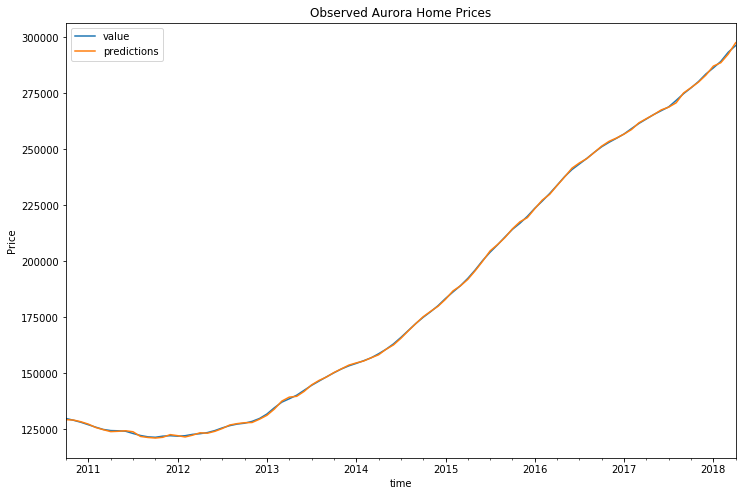

In [182]:
fig = plt.figure()
aurora_test.plot(figsize = (12, 8))
plt.title("Observed Aurora Home Prices")
plt.ylabel("Price")

5. Use ARIMA() function to forecast 3 years (36 months) into the future. 

In [28]:
aurora_forecast_model = ARIMA(melted_aurora, order = (4,2,0))
aurora_forecast_model_fit = aurora_forecast_model.fit(disp = 0)
aurora_yhat = aurora_forecast_model_fit.forecast(steps = 36)[0]

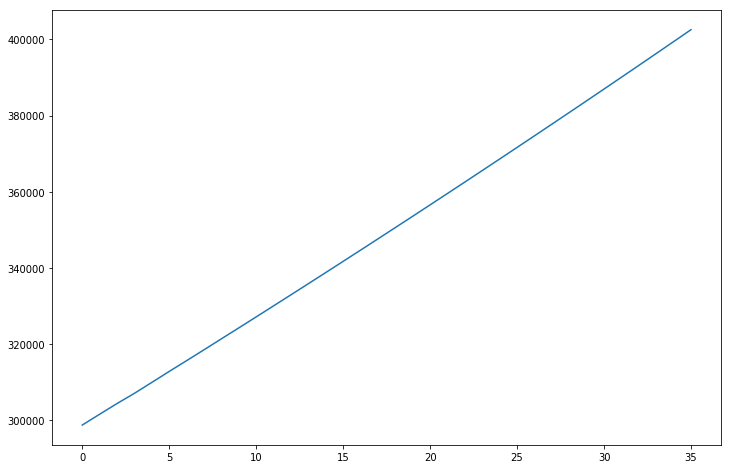

In [29]:
fig = plt.figure(figsize = (12, 8))
plt.plot(aurora_yhat)

In [30]:
len(aurora_test)

91

6. Use ROI formula, 3 year prediction and last recorded home value to calculate ROI. 

In [32]:
aurora_roi = (aurora_yhat[35]-aurora_test.iloc[90, 0])/aurora_test.iloc[90, 0]
aurora_roi

0.358107737815938

#### Conclusions
There is a 35.8% increase expected over the next three years in Aurora. 

### The above steps will be repeated for each zip code in the study. 

### Denver

In [33]:
arima_order(melted_denver, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=40095673265.237
ARIMA(0, 0, 1) MSE=10193008965.509
ARIMA(0, 1, 0) MSE=11547785.560
ARIMA(0, 1, 1) MSE=3524671.219
ARIMA(0, 2, 0) MSE=1153088.876
ARIMA(0, 2, 1) MSE=968977.256
ARIMA(0, 2, 2) MSE=1021261.459
Best ARIMA(0, 2, 1) MSE=968977.256
ARIMA(1, 0, 0) MSE=22411524.815
ARIMA(1, 1, 0) MSE=1138653.638
ARIMA(1, 1, 1) MSE=935621.705
ARIMA(1, 1, 2) MSE=991739.156
ARIMA(1, 2, 0) MSE=1069898.925
ARIMA(1, 2, 1) MSE=999819.477
ARIMA(1, 2, 2) MSE=963250.433
Best ARIMA(1, 1, 1) MSE=935621.705
ARIMA(2, 1, 0) MSE=1029680.855
ARIMA(2, 1, 1) MSE=971410.234
ARIMA(2, 1, 2) MSE=1001411.368
ARIMA(2, 2, 0) MSE=1015067.311
Best ARIMA(1, 1, 1) MSE=935621.705
ARIMA(4, 1, 0) MSE=1001735.325
ARIMA(4, 2, 0) MSE=1046374.984
Best ARIMA(1, 1, 1) MSE=935621.705
ARIMA(6, 1, 0) MSE=928715.085
ARIMA(6, 2, 0) MSE=968357.987
Best ARIMA(6, 1, 0) MSE=928715.085
ARIMA(8, 2, 0) MSE=1014907.489
Best ARIMA(6, 1, 0) MSE=928715.085
Best ARIMA(6, 1, 0) MSE=928715.085


In [34]:
denver_train_size = int(len(melted_denver)*.66)
denver_train, denver_test = melted_denver[0:denver_train_size], melted_denver[denver_train_size:]

In [35]:
denver_predictions = arima_predictions(melted_denver, (6,1,0))

In [36]:
denver_predictions_list = []
for x in denver_predictions:
    denver_predictions_list.append(x[0])

In [37]:
denver_test['predictions'] = denver_predictions_list

In [38]:
denver_test.head()

,value,predictions
time,,
2010-10-01,408000.0,407700.045187
2010-11-01,407500.0,405919.208117
2010-12-01,406400.0,408200.766458
2011-01-01,405200.0,404794.876096
2011-02-01,404800.0,404135.060620


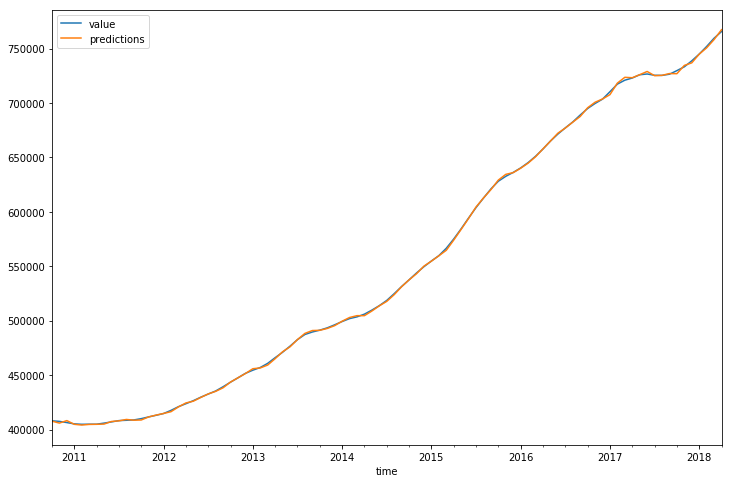

In [39]:
denver_test.plot(figsize = (12, 8))

In [40]:
denver_forecast_model = ARIMA(melted_denver, order = (6,1,0))
denver_forecast_model_fit = denver_forecast_model.fit(disp = 0)
denver_yhat = denver_forecast_model_fit.forecast(steps = 36)[0]

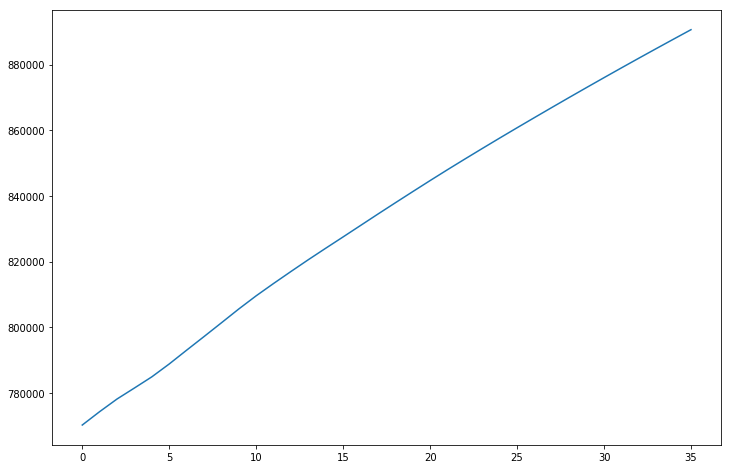

In [41]:
fig = plt.figure(figsize = (12, 8))
plt.plot(denver_yhat)

In [42]:
len(denver_test)

91

In [43]:
denver_roi = (denver_yhat[35]-denver_test.iloc[90, 0])/denver_test.iloc[90, 0]
denver_roi

0.16335497368538118

#### Conclusions 
There is a 16.3% increase expected over the next three years in Denver metro.

### Durango

In [44]:
arima_order(melted_durango, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=7763590485.368
ARIMA(0, 0, 1) MSE=1971916504.176
ARIMA(0, 1, 0) MSE=10206579.496
ARIMA(0, 1, 1) MSE=4642455.071
ARIMA(0, 2, 0) MSE=9023113.735
ARIMA(0, 2, 1) MSE=6597698.498
Best ARIMA(0, 1, 1) MSE=4642455.071
ARIMA(1, 0, 0) MSE=11150863.200
ARIMA(1, 1, 0) MSE=7802279.030
ARIMA(1, 2, 0) MSE=9785429.294
Best ARIMA(0, 1, 1) MSE=4642455.071
ARIMA(2, 0, 0) MSE=7986533.363
ARIMA(2, 1, 0) MSE=7606050.059
ARIMA(2, 2, 0) MSE=4058991.597
ARIMA(2, 2, 1) MSE=3944322.139
ARIMA(2, 2, 2) MSE=4673153.064
Best ARIMA(2, 2, 1) MSE=3944322.139
ARIMA(4, 0, 0) MSE=3912353.360
ARIMA(4, 1, 0) MSE=3729129.294
ARIMA(4, 1, 1) MSE=3766981.849
ARIMA(4, 1, 2) MSE=4001762.846
ARIMA(4, 2, 0) MSE=3908126.944
ARIMA(4, 2, 1) MSE=4024212.691
Best ARIMA(4, 1, 0) MSE=3729129.294
ARIMA(6, 0, 0) MSE=3747263.493
ARIMA(6, 0, 1) MSE=3831000.023
ARIMA(6, 2, 0) MSE=4131930.451
Best ARIMA(4, 1, 0) MSE=3729129.294
ARIMA(8, 1, 1) MSE=4266680.248
ARIMA(8, 2, 0) MSE=4309026.515
Best ARIMA(4, 1, 0) MSE=3729129.294
A

In [45]:
durango_train_size = int(len(melted_durango)*.66)
durango_train, durango_test = melted_durango[0:durango_train_size], melted_durango[durango_train_size:]

In [46]:
durango_predictions = arima_predictions(melted_durango, (4,1,0))

In [47]:
durango_predictions_list = []
for x in durango_predictions:
    durango_predictions_list.append(x[0])

In [48]:
durango_test["predictions"] = durango_predictions_list

In [49]:
durango_test.head()

,value,predictions
time,,
2010-10-01,357800.0,358168.269395
2010-11-01,359100.0,357959.768370
2010-12-01,359700.0,359744.018865
2011-01-01,359300.0,359921.334736
2011-02-01,357700.0,359242.426487


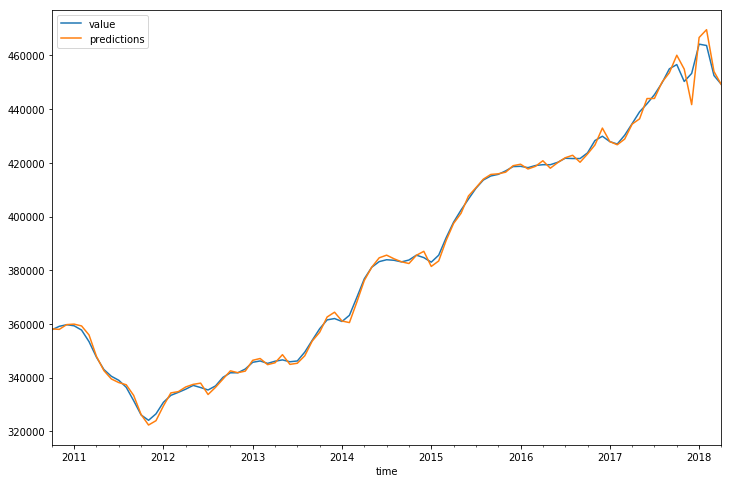

In [50]:
durango_test.plot(figsize = (12, 8))

In [51]:
durango_forecast_model = ARIMA(melted_durango, order = (4,1,0))
durango_forecast_model_fit = durango_forecast_model.fit(disp = 0)
durango_yhat = durango_forecast_model_fit.forecast(steps = 36)[0]

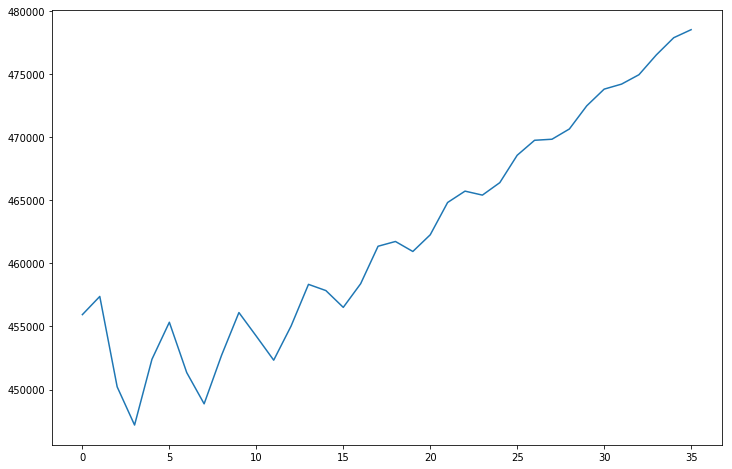

In [52]:
fig = plt.figure(figsize = (12, 8))
plt.plot(durango_yhat)

In [53]:
len(durango_test)

91

In [54]:
durango_roi = (durango_yhat[35]-durango_test.iloc[90, 0])/durango_test.iloc[90, 0]
durango_roi

0.06527404461292155

#### Conclusions
There is a 6.5% increase expected over the next three years in Durango.

### Boulder 1

In [55]:
arima_order(melted_boulder_1, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=27145919292.039
ARIMA(0, 0, 1) MSE=6889295800.345
ARIMA(0, 1, 0) MSE=12172505.356
ARIMA(0, 1, 1) MSE=3693078.489
ARIMA(0, 2, 0) MSE=1896680.809
ARIMA(0, 2, 1) MSE=1296589.967
Best ARIMA(0, 2, 1) MSE=1296589.967
ARIMA(1, 0, 0) MSE=18661240.118
ARIMA(1, 1, 0) MSE=1863802.279
ARIMA(1, 1, 1) MSE=1240985.030
ARIMA(1, 1, 2) MSE=1287579.215
ARIMA(1, 2, 0) MSE=1643892.847
ARIMA(1, 2, 1) MSE=1323779.578
ARIMA(1, 2, 2) MSE=1283031.713
Best ARIMA(1, 1, 1) MSE=1240985.030
ARIMA(2, 1, 0) MSE=1542980.536
ARIMA(2, 1, 1) MSE=1260017.800
ARIMA(2, 1, 2) MSE=1276878.469
ARIMA(2, 2, 0) MSE=1342775.054
ARIMA(2, 2, 1) MSE=1297332.752
ARIMA(2, 2, 2) MSE=1292064.106
Best ARIMA(1, 1, 1) MSE=1240985.030
ARIMA(4, 1, 0) MSE=1304108.233
ARIMA(4, 2, 0) MSE=1258571.636
ARIMA(4, 2, 1) MSE=1300583.603
Best ARIMA(1, 1, 1) MSE=1240985.030
ARIMA(6, 1, 0) MSE=1277521.727
ARIMA(6, 2, 0) MSE=1340842.671
ARIMA(6, 2, 1) MSE=1328355.719
Best ARIMA(1, 1, 1) MSE=1240985.030
ARIMA(8, 2, 0) MSE=1327174.092
Best 

In [56]:
boulder_1_train_size = int(len(melted_boulder_1)*.66)
boulder_1_train, boulder_1_test = melted_boulder_1[0:boulder_1_train_size], melted_boulder_1[boulder_1_train_size:]

In [57]:
boulder_1_predictions = arima_predictions(melted_boulder_1, (1,1,1))

In [58]:
boulder_1_predictions_list = []
for x in boulder_1_predictions:
    boulder_1_predictions_list.append(x[0])

In [59]:
boulder_1_test["predictions"] = boulder_1_predictions_list

In [60]:
boulder_1_test.head()

,value,predictions
time,,
2010-10-01,394800.0,395315.194065
2010-11-01,393100.0,392478.815948
2010-12-01,393800.0,391774.838356
2011-01-01,396300.0,395479.671189
2011-02-01,396900.0,399110.749494


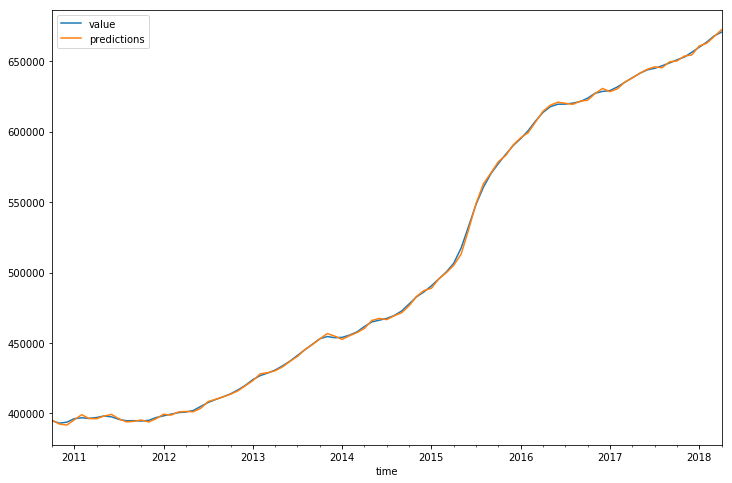

In [61]:
boulder_1_test.plot(figsize = (12,8))

In [62]:
boulder_1_forecast_model = ARIMA(melted_boulder_1, order = (1,1,1))
boulder_1_forecast_model_fit = boulder_1_forecast_model.fit(disp = 0)
boulder_1_yhat = boulder_1_forecast_model_fit.forecast(steps = 36)[0]

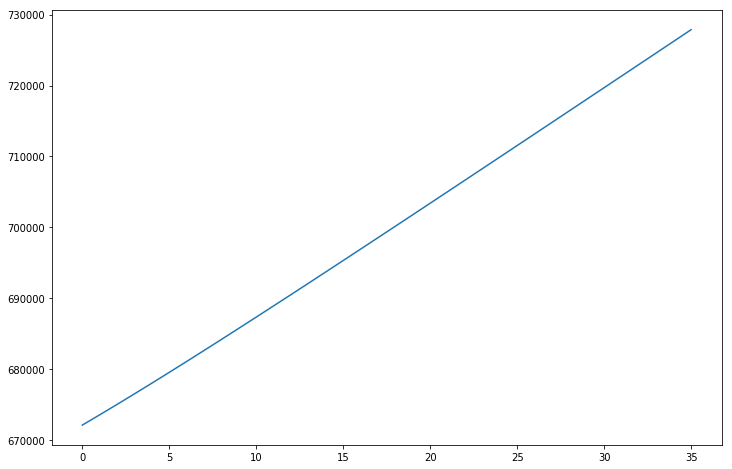

In [63]:
fig = plt.figure(figsize = (12, 8))
plt.plot(boulder_1_yhat)

In [64]:
len(boulder_1_test)

91

In [65]:
boulder_1_roi = (boulder_1_yhat[35]-boulder_1_test.iloc[90, 0])/boulder_1_test.iloc[90, 0]
boulder_1_roi

0.08525298546466581

#### Conclusions
There is a 8.5% increase expected over the next three years in Boulder-81301.

### Boulder 2

In [66]:
arima_order(melted_boulder_2, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=46696022969.923
ARIMA(0, 0, 1) MSE=11880597312.868
ARIMA(0, 1, 0) MSE=14082650.824
ARIMA(0, 1, 1) MSE=4701037.272
ARIMA(0, 2, 0) MSE=2740025.162
ARIMA(0, 2, 1) MSE=2249323.500
Best ARIMA(0, 2, 1) MSE=2249323.500
ARIMA(1, 0, 0) MSE=25644148.312
ARIMA(1, 1, 0) MSE=2656511.717
ARIMA(1, 1, 2) MSE=2282544.509
ARIMA(1, 2, 0) MSE=2846670.228
ARIMA(1, 2, 1) MSE=2404116.045
ARIMA(1, 2, 2) MSE=2234201.067
Best ARIMA(1, 2, 2) MSE=2234201.067
ARIMA(2, 1, 0) MSE=2645933.053
ARIMA(2, 1, 1) MSE=2247832.578
ARIMA(2, 1, 2) MSE=2072713.125
ARIMA(2, 2, 0) MSE=2275693.111
ARIMA(2, 2, 1) MSE=2259661.709
ARIMA(2, 2, 2) MSE=2282736.493
Best ARIMA(2, 1, 2) MSE=2072713.125
ARIMA(4, 1, 0) MSE=2231094.176
ARIMA(4, 2, 0) MSE=2291458.598
ARIMA(4, 2, 1) MSE=2316035.239
Best ARIMA(2, 1, 2) MSE=2072713.125
ARIMA(6, 1, 0) MSE=2279688.305
ARIMA(6, 1, 1) MSE=2303345.359
ARIMA(6, 2, 0) MSE=2382467.613
ARIMA(6, 2, 1) MSE=2347634.894
Best ARIMA(2, 1, 2) MSE=2072713.125
ARIMA(8, 1, 0) MSE=2330481.535
ARIM

In [67]:
boulder_2_train_size = int(len(melted_boulder_2)*.66)
boulder_2_train, boulder_2_test = melted_boulder_2[0:boulder_2_train_size], melted_boulder_2[boulder_2_train_size:]

In [68]:
boulder_2_predictions = arima_predictions(melted_boulder_2, (2,1,2))

In [69]:
boulder_2_predictions_list = []
for x in boulder_2_predictions:
    boulder_2_predictions_list.append(x[0])

In [70]:
boulder_2_test["predictions"] = boulder_2_predictions_list

In [71]:
boulder_2_test.head()

,value,predictions
time,,
2010-10-01,550700.0,548834.366795
2010-11-01,547500.0,543745.179513
2010-12-01,549400.0,549826.939077
2011-01-01,552000.0,553040.904957
2011-02-01,552000.0,553130.157142


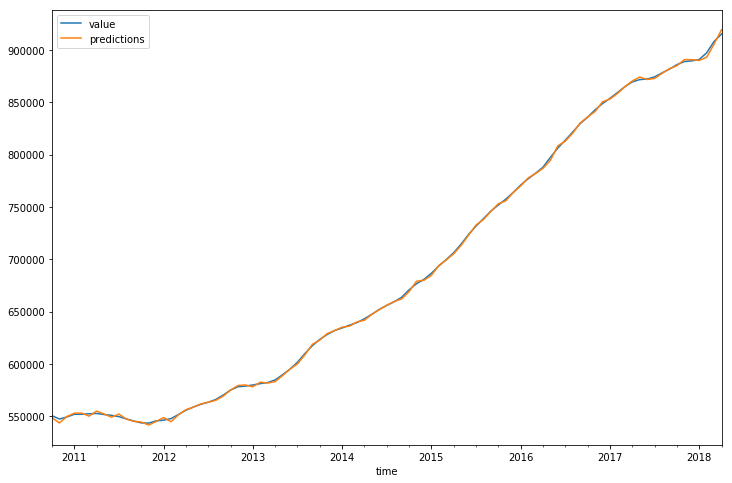

In [72]:
boulder_2_test.plot(figsize = (12, 8))

In [73]:
boulder_2_forecast_model = ARIMA(melted_boulder_2, order = (2,1,2))
boulder_2_forecast_model_fit = boulder_2_forecast_model.fit(disp = 0)
boulder_2_yhat = boulder_2_forecast_model_fit.forecast(steps = 36)[0]

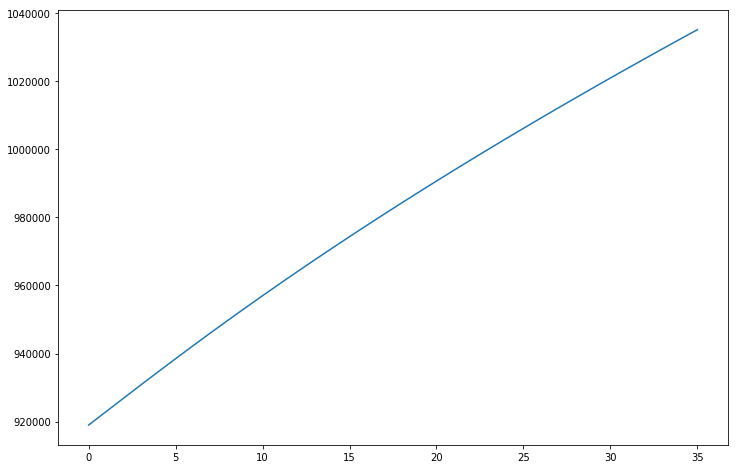

In [74]:
fig = plt.figure(figsize = (12, 8))
plt.plot(boulder_2_yhat)

In [75]:
len(boulder_2_test)

91

In [76]:
boulder_2_roi = (boulder_2_yhat[35]-boulder_2_test.iloc[90, 0])/boulder_2_test.iloc[90, 0]
boulder_2_roi

0.13119038892413398

#### Conclusions:
There is a 13.1% increase expected over the next three years in Boulder-81302.

### Boulder 3

In [77]:
arima_order(melted_boulder_3, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=36203000727.018
ARIMA(0, 0, 1) MSE=9180383441.234
ARIMA(0, 1, 0) MSE=13379415.505
ARIMA(0, 1, 1) MSE=4238320.334
ARIMA(0, 2, 0) MSE=3313875.585
ARIMA(0, 2, 1) MSE=2169944.009
Best ARIMA(0, 2, 1) MSE=2169944.009
ARIMA(1, 0, 0) MSE=21074199.969
ARIMA(1, 1, 0) MSE=3175558.306
ARIMA(1, 2, 0) MSE=3292349.065
Best ARIMA(0, 2, 1) MSE=2169944.009
ARIMA(2, 1, 0) MSE=3029502.562
ARIMA(2, 2, 0) MSE=1849255.453
ARIMA(2, 2, 1) MSE=1491830.657
Best ARIMA(2, 2, 1) MSE=1491830.657
ARIMA(4, 1, 0) MSE=1441752.193
ARIMA(4, 1, 1) MSE=1419744.198
ARIMA(4, 1, 2) MSE=1278188.243
ARIMA(4, 2, 0) MSE=1464709.249
ARIMA(4, 2, 1) MSE=1498015.686
Best ARIMA(4, 1, 2) MSE=1278188.243
ARIMA(6, 1, 0) MSE=1466095.535
ARIMA(6, 1, 1) MSE=1428664.169
ARIMA(6, 2, 0) MSE=1537323.879
ARIMA(6, 2, 1) MSE=1466061.159
Best ARIMA(4, 1, 2) MSE=1278188.243
ARIMA(8, 2, 0) MSE=1477946.529
Best ARIMA(4, 1, 2) MSE=1278188.243
ARIMA(10, 1, 0) MSE=1380428.733
ARIMA(10, 2, 0) MSE=1431101.091
Best ARIMA(4, 1, 2) MSE=12781

In [78]:
boulder_3_train_size = int(len(melted_boulder_3)*.66)
boulder_3_train, boulder_3_test = melted_boulder_3[0:boulder_3_train_size], melted_boulder_3[boulder_3_train_size:]

In [79]:
boulder_3_predictions = arima_predictions(melted_boulder_3, (4,1,2))

In [80]:
boulder_3_predictions_list = []
for x in boulder_3_predictions:
    boulder_3_predictions_list.append(x[0])

In [81]:
boulder_3_test["predictions"] = boulder_3_predictions_list

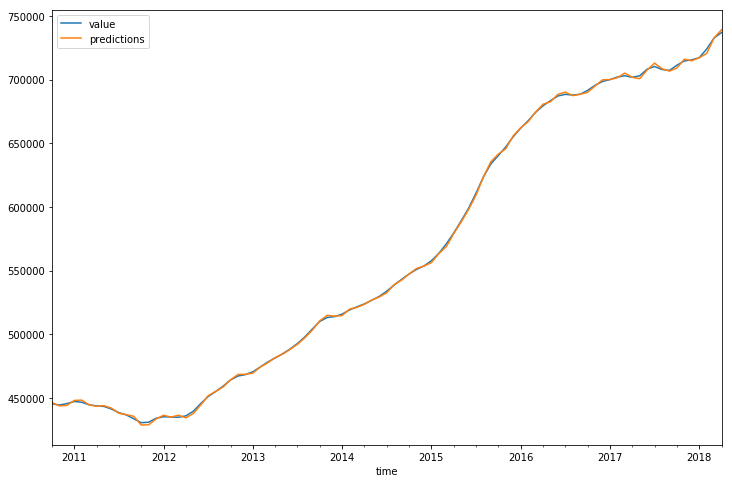

In [82]:
boulder_3_test.plot(figsize = (12, 8))

In [83]:
boulder_3_forecast_model = ARIMA(melted_boulder_3, order = (4,1,2))
boulder_3_forecast_model_fit = boulder_3_forecast_model.fit(disp = 0)
boulder_3_yhat = boulder_3_forecast_model_fit.forecast(steps = 36)[0]

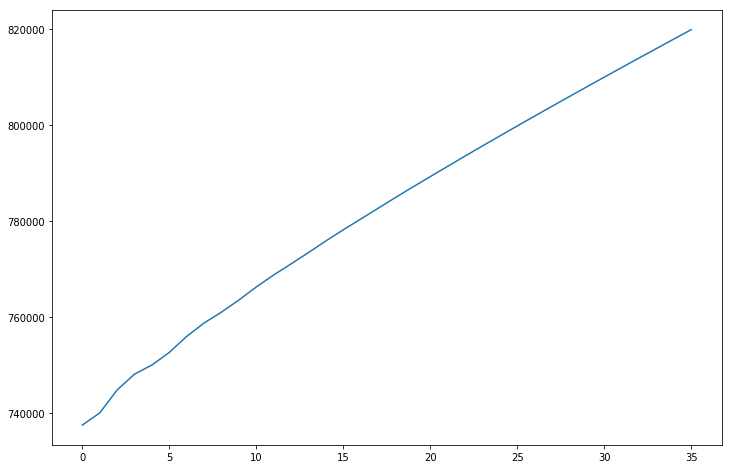

In [84]:
fig = plt.figure(figsize = (12, 8))
plt.plot(boulder_3_yhat)

In [85]:
len(boulder_3_test)

91

In [86]:
boulder_3_roi = (boulder_3_yhat[35]-boulder_3_test.iloc[90, 0])/boulder_3_test.iloc[90, 0]
boulder_3_roi

0.11224534853579658

#### Conclusions:
There is a 11.2% increase expected over the next three years in Boulder-81303.

### Grand Junction 1

In [87]:
arima_order(melted_grand_junction_1, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=695171523.737
ARIMA(0, 0, 1) MSE=177951774.698
ARIMA(0, 1, 0) MSE=1208679.799
ARIMA(0, 1, 1) MSE=378697.787
ARIMA(0, 2, 0) MSE=367156.689
ARIMA(0, 2, 1) MSE=271994.054
ARIMA(0, 2, 2) MSE=239023.766
Best ARIMA(0, 2, 2) MSE=239023.766
ARIMA(1, 0, 0) MSE=1325577.094
ARIMA(1, 1, 0) MSE=347433.817
ARIMA(1, 1, 1) MSE=239597.297
ARIMA(1, 1, 2) MSE=231022.348
ARIMA(1, 2, 0) MSE=362626.276
ARIMA(1, 2, 1) MSE=268838.998
ARIMA(1, 2, 2) MSE=227428.723
Best ARIMA(1, 2, 2) MSE=227428.723
ARIMA(2, 0, 1) MSE=245093.174
ARIMA(2, 0, 2) MSE=234734.884
ARIMA(2, 1, 0) MSE=334639.335
ARIMA(2, 1, 1) MSE=243737.493
ARIMA(2, 1, 2) MSE=221224.084
ARIMA(2, 2, 0) MSE=228598.953
ARIMA(2, 2, 1) MSE=199183.156
Best ARIMA(2, 2, 1) MSE=199183.156
ARIMA(4, 0, 1) MSE=195128.564
ARIMA(4, 1, 0) MSE=202869.668
ARIMA(4, 1, 1) MSE=196390.473
ARIMA(4, 2, 0) MSE=197551.181
ARIMA(4, 2, 1) MSE=196472.253
Best ARIMA(4, 0, 1) MSE=195128.564
ARIMA(6, 1, 1) MSE=195851.179
ARIMA(6, 2, 0) MSE=204578.486
Best ARIMA(4

In [88]:
grand_junction_1_train_size = int(len(melted_grand_junction_1)*.66)
grand_junction_1_train, grand_junction_1_test = melted_grand_junction_1[0:grand_junction_1_train_size], melted_grand_junction_1[grand_junction_1_train_size:]

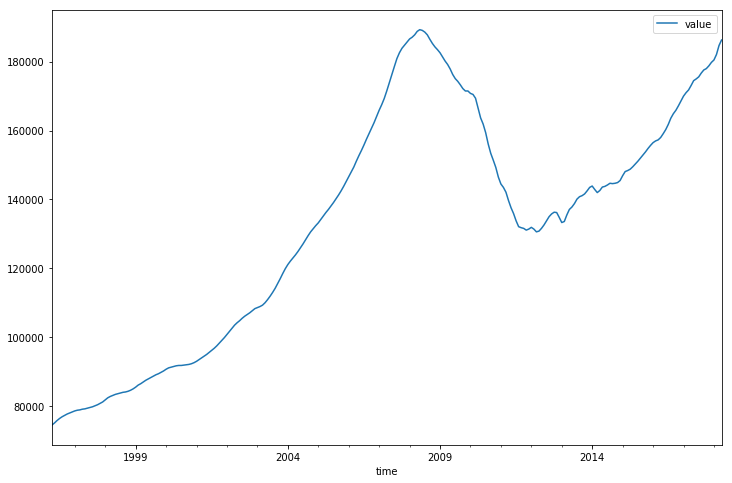

In [89]:
melted_grand_junction_1.plot(figsize = (12, 8))

In [90]:
grand_junction_1_predictions = arima_predictions(melted_grand_junction_1, (4,0,1))

In [91]:
grand_junction_1_predictions_list = []
for x in grand_junction_1_predictions:
    grand_junction_1_predictions_list.append(x[0])

In [92]:
grand_junction_1_test["predictions"] = grand_junction_1_predictions_list

In [93]:
grand_junction_1_test.head()

,value,predictions
time,,
2010-10-01,151400.0,150989.269326
2010-11-01,149300.0,149220.103253
2010-12-01,146500.0,146981.943895
2011-01-01,144500.0,143644.661968
2011-02-01,143500.0,142985.493807


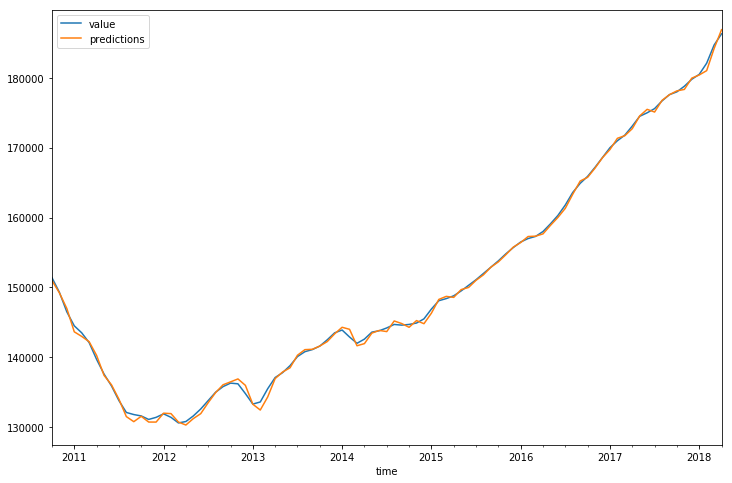

In [94]:
grand_junction_1_test.plot(figsize = (12, 8))

In [95]:
grand_junction_1_forecast_model = ARIMA(melted_grand_junction_1, order = (4,0,1))
grand_junction_1_forecast_model_fit = grand_junction_1_forecast_model.fit(disp = 0)
grand_junction_1_yhat = grand_junction_1_forecast_model_fit.forecast(steps = 36)[0]

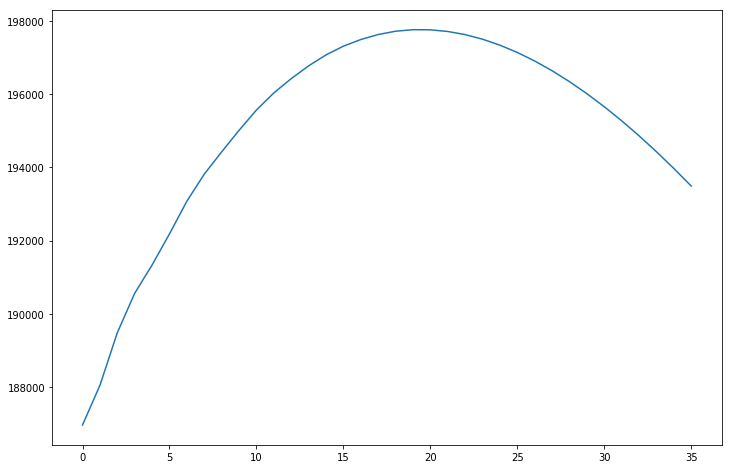

In [96]:
fig = plt.figure(figsize = (12,8))
plt.plot(grand_junction_1_yhat)

In [97]:
len(grand_junction_1_test)

91

In [98]:
grand_junction_1_roi = (grand_junction_1_yhat[35]-grand_junction_1_test.iloc[90, 0])/grand_junction_1_test.iloc[90, 0]
grand_junction_1_roi

0.03858821615068325

#### Conclusions:
There is a 3.8% increase expected over the next three years in Grand Junction-81501. This is after a peak in 2020. 

### Montrose

In [99]:
arima_order(melted_montrose, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=1191487818.860
ARIMA(0, 1, 0) MSE=3226076.361
ARIMA(0, 1, 1) MSE=1237804.486
ARIMA(0, 2, 0) MSE=1025017.951
ARIMA(0, 2, 1) MSE=769591.754
Best ARIMA(0, 2, 1) MSE=769591.754
ARIMA(1, 1, 0) MSE=1003303.740
ARIMA(1, 1, 1) MSE=712053.108
ARIMA(1, 1, 2) MSE=693209.479
ARIMA(1, 2, 0) MSE=964063.207
ARIMA(1, 2, 1) MSE=813554.664
ARIMA(1, 2, 2) MSE=768929.799
Best ARIMA(1, 1, 2) MSE=693209.479
ARIMA(2, 0, 1) MSE=710706.872
ARIMA(2, 0, 2) MSE=708608.803
ARIMA(2, 1, 0) MSE=858149.120
ARIMA(2, 1, 1) MSE=738220.005
ARIMA(2, 1, 2) MSE=702207.834
ARIMA(2, 2, 0) MSE=751945.036
ARIMA(2, 2, 1) MSE=764473.211
Best ARIMA(1, 1, 2) MSE=693209.479
ARIMA(4, 1, 0) MSE=728363.572
ARIMA(4, 1, 1) MSE=753013.543
ARIMA(4, 2, 0) MSE=783117.473
Best ARIMA(1, 1, 2) MSE=693209.479
ARIMA(6, 1, 0) MSE=748886.266
ARIMA(6, 1, 1) MSE=700048.289
ARIMA(6, 2, 0) MSE=781080.285
ARIMA(6, 2, 1) MSE=735133.930
Best ARIMA(1, 1, 2) MSE=693209.479
ARIMA(8, 1, 0) MSE=689639.003
ARIMA(8, 2, 0) MSE=718449.826
Best AR

In [100]:
montrose_train_size = int(len(melted_montrose)*.66)
montrose_train, montrose_test = melted_montrose[0:montrose_train_size], melted_montrose[montrose_train_size:]

In [101]:
montrose_predictions = arima_predictions(melted_montrose, (8,1,0))

In [102]:
montrose_predictions_list = []
for x in montrose_predictions:
    montrose_predictions_list.append(x[0])

In [103]:
montrose_test["predictions"] = montrose_predictions_list

In [104]:
montrose_test.head()

,value,predictions
time,,
2010-10-01,172300.0,172246.539517
2010-11-01,169700.0,170316.962070
2010-12-01,166100.0,166913.098784
2011-01-01,162800.0,161983.435736
2011-02-01,160400.0,159886.160822


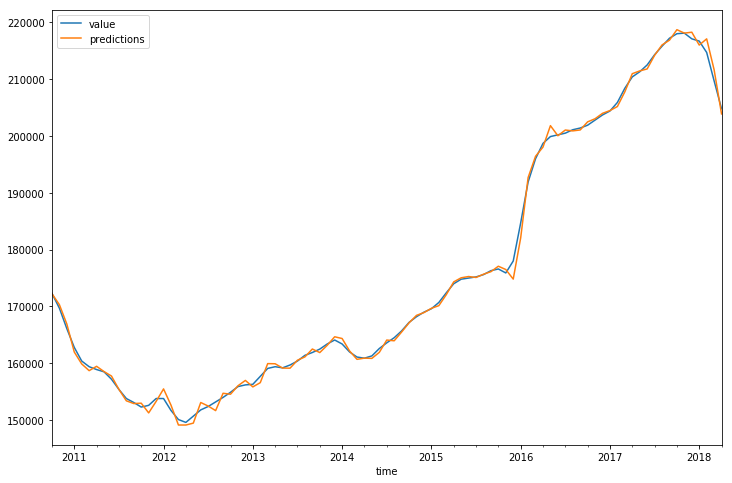

In [105]:
montrose_test.plot(figsize = (12,8))

In [106]:
montrose_forecast_model = ARIMA(melted_montrose, order = (8,1,0))
montrose_forecast_model_fit = montrose_forecast_model.fit(disp = 0)
montrose_yhat = montrose_forecast_model_fit.forecast(steps = 36)[0]

Text(0, 0.5, 'Price')

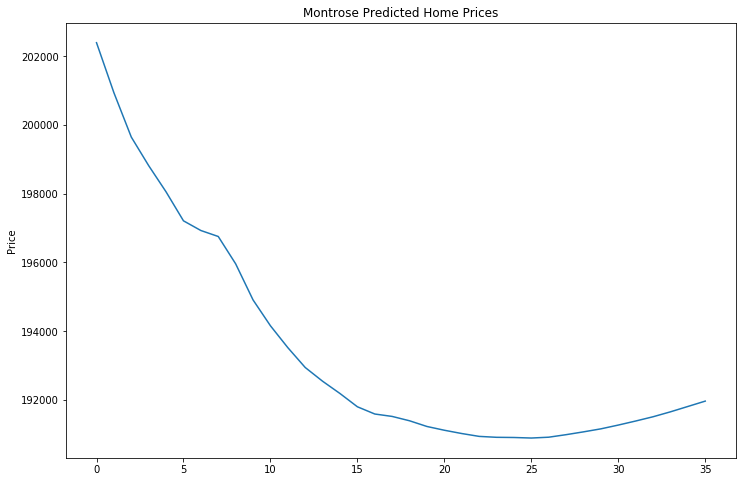

In [183]:
fig = plt.figure(figsize = (12, 8))
plt.plot(montrose_yhat)
plt.title("Montrose Predicted Home Prices")
plt.ylabel("Price")

In [108]:
len(montrose_test)

91

In [109]:
montrose_roi = (montrose_yhat[35]-montrose_test.iloc[90, 0])/montrose_test.iloc[90, 0]
montrose_roi

-0.06265953530365934

#### Conclusions:
There is a 6.2% decrease expected over the next three years in Montrose.

### Colorado Springs

In [110]:
arima_order(melted_colorado_springs, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=1962209663.793
ARIMA(0, 0, 1) MSE=504202913.047
ARIMA(0, 1, 0) MSE=1595147.510
ARIMA(0, 1, 1) MSE=509853.519
ARIMA(0, 2, 0) MSE=296777.904
ARIMA(0, 2, 1) MSE=235646.735
ARIMA(0, 2, 2) MSE=242302.252
Best ARIMA(0, 2, 1) MSE=235646.735
ARIMA(1, 0, 0) MSE=2404624.412
ARIMA(1, 1, 0) MSE=288931.579
ARIMA(1, 1, 1) MSE=218510.697
ARIMA(1, 1, 2) MSE=225598.471
ARIMA(1, 2, 0) MSE=276815.128
ARIMA(1, 2, 1) MSE=237308.927
Best ARIMA(1, 1, 1) MSE=218510.697
ARIMA(2, 1, 0) MSE=255398.130
ARIMA(2, 1, 1) MSE=222302.923
ARIMA(2, 2, 0) MSE=227823.828
ARIMA(2, 2, 1) MSE=238480.218
Best ARIMA(1, 1, 1) MSE=218510.697
ARIMA(4, 1, 0) MSE=225531.135
ARIMA(4, 2, 0) MSE=224368.228
Best ARIMA(1, 1, 1) MSE=218510.697
ARIMA(6, 1, 0) MSE=224170.369
ARIMA(6, 2, 0) MSE=225979.625
ARIMA(6, 2, 1) MSE=223639.493
Best ARIMA(1, 1, 1) MSE=218510.697
ARIMA(8, 1, 0) MSE=223451.035
ARIMA(8, 2, 0) MSE=228520.302
ARIMA(8, 2, 1) MSE=228977.211
Best ARIMA(1, 1, 1) MSE=218510.697
ARIMA(10, 2, 0) MSE=238739.413


In [111]:
colorado_springs_train_size = int(len(melted_colorado_springs)*.66)
colorado_springs_train, colorado_springs_test = melted_colorado_springs[0:colorado_springs_train_size], melted_colorado_springs[colorado_springs_train_size:]

In [112]:
colorado_springs_predictions = arima_predictions(melted_colorado_springs, (1,1,1))

In [113]:
colorado_springs_predictions_list = []
for x in colorado_springs_predictions:
    colorado_springs_predictions_list.append(x[0])

In [114]:
colorado_springs_test["predictions"] = colorado_springs_predictions_list

In [115]:
colorado_springs_test.head()

,value,predictions
time,,
2010-10-01,155700.0,155118.340518
2010-11-01,155200.0,155234.364898
2010-12-01,154100.0,154750.971078
2011-01-01,152300.0,152884.431366
2011-02-01,151300.0,150397.449072


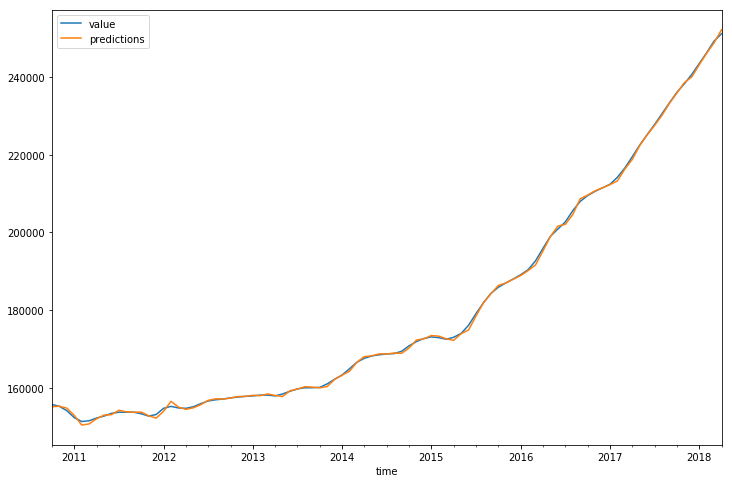

In [116]:
colorado_springs_test.plot(figsize = (12,8))

In [117]:
colorado_springs_forecast_model = ARIMA(melted_colorado_springs, order = (1,1,1))
colorado_springs_forecast_model_fit = colorado_springs_forecast_model.fit(disp = 0)
colorado_springs_yhat = colorado_springs_forecast_model_fit.forecast(steps = 36)[0]

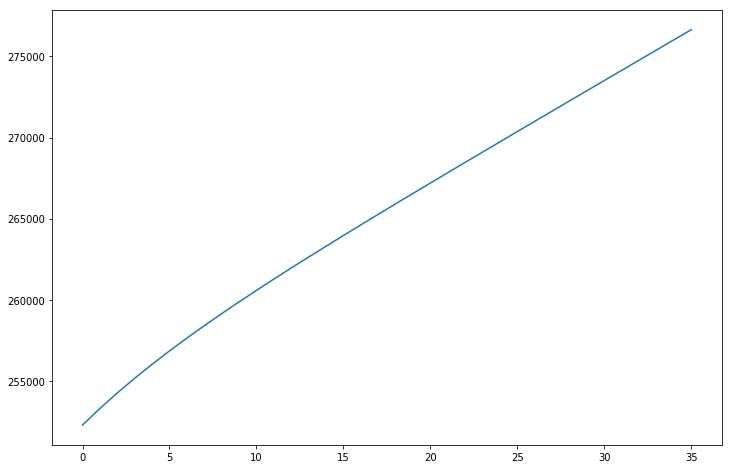

In [118]:
fig = plt.figure(figsize = (12, 8))
plt.plot(colorado_springs_yhat)

In [119]:
len(colorado_springs_test)

91

In [120]:
colorado_springs_roi = (colorado_springs_yhat[35]-colorado_springs_test.iloc[90, 0])/colorado_springs_test.iloc[90, 0]
colorado_springs_roi

0.10128050870364552

#### Conclusions
There is a 10.1% increase expected over the next three years in Colorado Springs.

### Cortez

In [121]:
arima_order(melted_cortez, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=892523613.255
ARIMA(0, 0, 1) MSE=224087712.414
ARIMA(0, 1, 0) MSE=1543285.406
ARIMA(0, 1, 1) MSE=606536.458
ARIMA(0, 2, 0) MSE=850191.879
ARIMA(0, 2, 1) MSE=750530.137
Best ARIMA(0, 1, 1) MSE=606536.458
ARIMA(1, 0, 0) MSE=1459909.694
ARIMA(1, 1, 0) MSE=790653.279
ARIMA(1, 1, 1) MSE=652948.868
ARIMA(1, 2, 0) MSE=991744.557
Best ARIMA(0, 1, 1) MSE=606536.458
ARIMA(2, 0, 0) MSE=798734.475
ARIMA(2, 1, 0) MSE=849143.251
ARIMA(2, 1, 2) MSE=609997.491
ARIMA(2, 2, 0) MSE=636909.624
Best ARIMA(0, 1, 1) MSE=606536.458
ARIMA(4, 0, 0) MSE=619602.103
ARIMA(4, 1, 0) MSE=597256.109
ARIMA(4, 2, 0) MSE=632378.818
ARIMA(4, 2, 1) MSE=654951.256
Best ARIMA(4, 1, 0) MSE=597256.109
ARIMA(6, 0, 0) MSE=609705.970
ARIMA(6, 0, 1) MSE=634854.686
ARIMA(6, 1, 0) MSE=612898.854
ARIMA(6, 1, 1) MSE=591736.815
ARIMA(6, 2, 0) MSE=644463.750
Best ARIMA(6, 1, 1) MSE=591736.815
ARIMA(8, 0, 0) MSE=626934.741
ARIMA(8, 1, 0) MSE=575903.160
ARIMA(8, 2, 0) MSE=593709.059
Best ARIMA(8, 1, 0) MSE=575903.160
AR

In [122]:
cortez_train_size = int(len(melted_cortez)*.66)
cortez_train, cortez_test = melted_cortez[0:cortez_train_size], melted_cortez[cortez_train_size:]

In [123]:
cortez_predictions = arima_predictions(melted_cortez, (8,1,0))

In [124]:
cortez_predictions_list = []
for x in cortez_predictions:
    cortez_predictions_list.append(x[0])

In [125]:
cortez_test["predictions"] = cortez_predictions_list

In [126]:
cortez_test.head()

,value,predictions
time,,
2010-10-01,160400.0,160180.406548
2010-11-01,159200.0,159412.462585
2010-12-01,157600.0,158053.983665
2011-01-01,155900.0,155890.147619
2011-02-01,154200.0,154222.935657


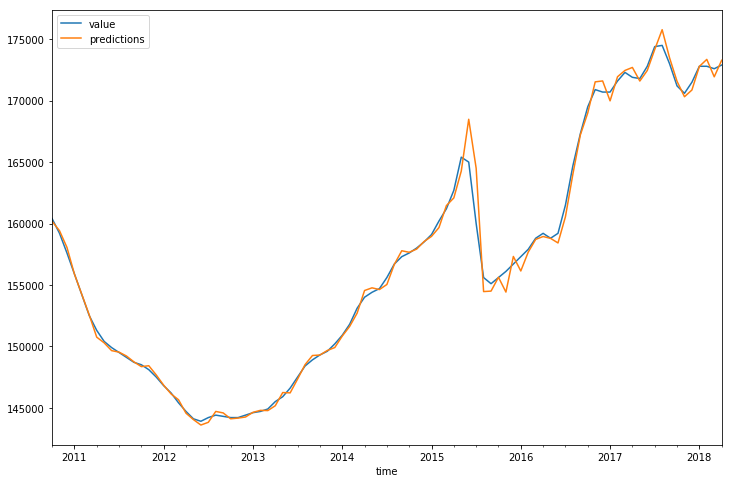

In [127]:
cortez_test.plot(figsize = (12, 8))

In [128]:
cortez_forecast_model = ARIMA(melted_cortez, order = (8,1,0))
cortez_forecast_model_fit = cortez_forecast_model.fit(disp = 0)
cortez_yhat = cortez_forecast_model_fit.forecast(steps = 36)[0]

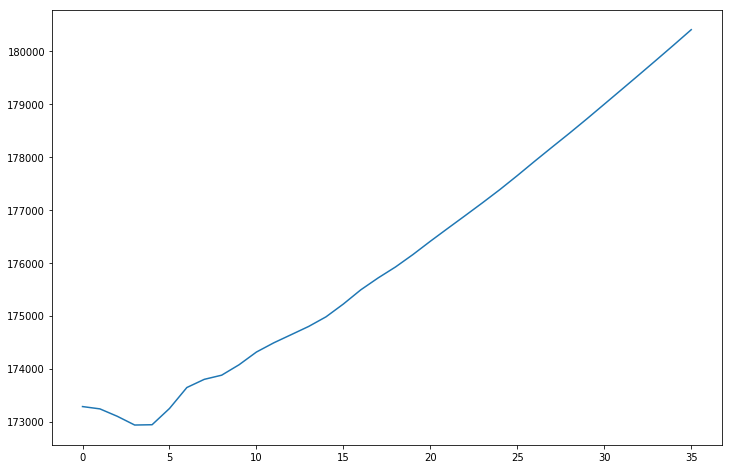

In [129]:
fig = plt.figure(figsize = (12, 8))
plt.plot(cortez_yhat)

In [130]:
len(cortez_test)

91

In [131]:
cortez_roi = (cortez_yhat[35]-cortez_test.iloc[90, 0])/cortez_test.iloc[90, 0]
cortez_roi

0.04338223269741955

#### Conclusions
There is a 4.3% increase expected over the next three years in Cortez.

### Grand Junction 2

In [132]:
arima_order(melted_grand_junction_2, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=3611079832.216
ARIMA(0, 0, 1) MSE=920063183.540
ARIMA(0, 1, 0) MSE=3645209.179
ARIMA(0, 1, 1) MSE=1293180.375
ARIMA(0, 2, 0) MSE=1668358.363
ARIMA(0, 2, 1) MSE=1168290.188
Best ARIMA(0, 2, 1) MSE=1168290.188
ARIMA(1, 0, 0) MSE=4171081.857
ARIMA(1, 1, 0) MSE=1538927.481
ARIMA(1, 1, 1) MSE=1008299.478
ARIMA(1, 1, 2) MSE=889930.226
ARIMA(1, 2, 0) MSE=1582198.843
ARIMA(1, 2, 1) MSE=1193035.854
ARIMA(1, 2, 2) MSE=1020226.264
Best ARIMA(1, 1, 2) MSE=889930.226
ARIMA(2, 0, 0) MSE=1575844.580
ARIMA(2, 0, 2) MSE=935392.199
ARIMA(2, 1, 0) MSE=1347907.033
ARIMA(2, 1, 1) MSE=1013745.465
ARIMA(2, 1, 2) MSE=916957.769
ARIMA(2, 2, 0) MSE=934423.215
ARIMA(2, 2, 1) MSE=899986.644
ARIMA(2, 2, 2) MSE=954037.878
Best ARIMA(1, 1, 2) MSE=889930.226
ARIMA(4, 0, 0) MSE=908128.266
ARIMA(4, 0, 1) MSE=865386.151
ARIMA(4, 0, 2) MSE=872998.674
ARIMA(4, 1, 0) MSE=846833.454
ARIMA(4, 1, 1) MSE=909862.483
ARIMA(4, 2, 0) MSE=896334.495
Best ARIMA(4, 1, 0) MSE=846833.454
ARIMA(6, 0, 0) MSE=865738.448

In [133]:
grand_junction_2_train_size = int(len(melted_grand_junction_2)*.66)
grand_junction_2_train, grand_junction_2_test = melted_grand_junction_2[0:grand_junction_2_train_size], melted_grand_junction_2[grand_junction_2_train_size:]

In [134]:
grand_junction_2_predictions = arima_predictions(melted_grand_junction_2, (4,1,0))

In [135]:
grand_junction_2_predictions_list = []
for x in grand_junction_2_predictions:
    grand_junction_2_predictions_list.append(x[0])

In [136]:
grand_junction_2_test["predictions"] = grand_junction_2_predictions_list

In [137]:
grand_junction_2_test.head()

,value,predictions
time,,
2010-10-01,269200.0,268442.414658
2010-11-01,264600.0,265353.906900
2010-12-01,260300.0,259765.700284
2011-01-01,258600.0,256021.588070
2011-02-01,258900.0,258721.512454


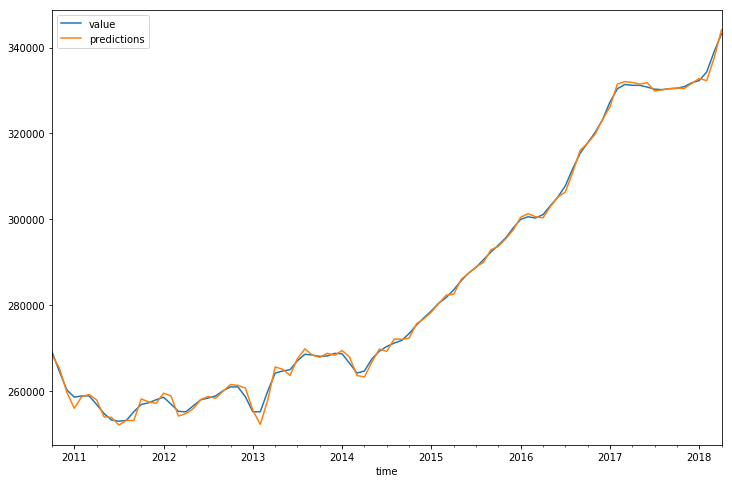

In [138]:
grand_junction_2_test.plot(figsize = (12,8))

In [139]:
grand_junction_2_forecast_model = ARIMA(melted_grand_junction_2, order = (4,1,0))
grand_junction_2_forecast_model_fit = grand_junction_2_forecast_model.fit(disp = 0)
grand_junction_2_yhat = grand_junction_2_forecast_model_fit.forecast(steps = 36)[0]

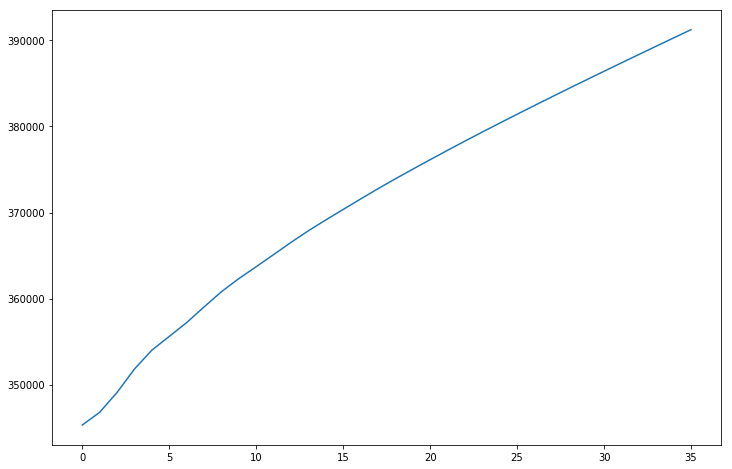

In [140]:
fig = plt.figure(figsize = (12, 8))
plt.plot(grand_junction_2_yhat)

In [141]:
len(grand_junction_2_test)

91

In [142]:
grand_junction_2_roi = (grand_junction_2_yhat[35]-grand_junction_2_test.iloc[90, 0])/grand_junction_2_test.iloc[90, 0]
grand_junction_2_roi

0.1400034415006499

#### Conclusions
There is a 14.0% increase expected over the next three years in Grand Junction-81507.

### Fruita

In [143]:
arima_order(melted_fruita, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=2910955361.039
ARIMA(0, 1, 0) MSE=1521657.267
ARIMA(0, 1, 1) MSE=655446.214
ARIMA(0, 2, 0) MSE=625724.946
ARIMA(0, 2, 1) MSE=499645.655
Best ARIMA(0, 2, 1) MSE=499645.655
ARIMA(1, 1, 0) MSE=581752.181
ARIMA(1, 1, 1) MSE=441400.439
ARIMA(1, 1, 2) MSE=465115.107
ARIMA(1, 2, 0) MSE=648259.961
ARIMA(1, 2, 1) MSE=529401.944
ARIMA(1, 2, 2) MSE=455156.236
Best ARIMA(1, 1, 1) MSE=441400.439
ARIMA(2, 0, 1) MSE=454949.268
ARIMA(2, 0, 2) MSE=480827.427
ARIMA(2, 1, 0) MSE=568560.751
ARIMA(2, 1, 1) MSE=469227.919
ARIMA(2, 1, 2) MSE=416871.703
ARIMA(2, 2, 0) MSE=507854.622
ARIMA(2, 2, 1) MSE=496241.895
ARIMA(2, 2, 2) MSE=463336.882
Best ARIMA(2, 1, 2) MSE=416871.703
ARIMA(4, 0, 1) MSE=462655.939
ARIMA(4, 1, 0) MSE=456355.803
ARIMA(4, 1, 1) MSE=449606.694
ARIMA(4, 2, 0) MSE=467889.138
ARIMA(4, 2, 1) MSE=436323.432
ARIMA(4, 2, 2) MSE=453250.519
Best ARIMA(2, 1, 2) MSE=416871.703
ARIMA(6, 1, 0) MSE=433621.584
ARIMA(6, 1, 1) MSE=444000.029
ARIMA(6, 2, 0) MSE=456987.602
ARIMA(6, 2, 1) 

In [144]:
fruita_train_size = int(len(melted_fruita)*.66)
fruita_train, fruita_test = melted_fruita[0:fruita_train_size], melted_fruita[fruita_train_size:]

In [145]:
fruita_predictions = arima_predictions(melted_fruita, (2,1,2))

In [146]:
fruita_predictions_list = []
for x in fruita_predictions:
    fruita_predictions_list.append(x[0])

In [147]:
fruita_test["predictions"] = fruita_predictions_list

In [148]:
fruita_test.head()

,value,predictions
time,,
2010-10-01,202700.0,202081.687596
2010-11-01,200900.0,201560.678919
2010-12-01,199100.0,199039.952698
2011-01-01,197900.0,197421.784623
2011-02-01,196900.0,197533.749242


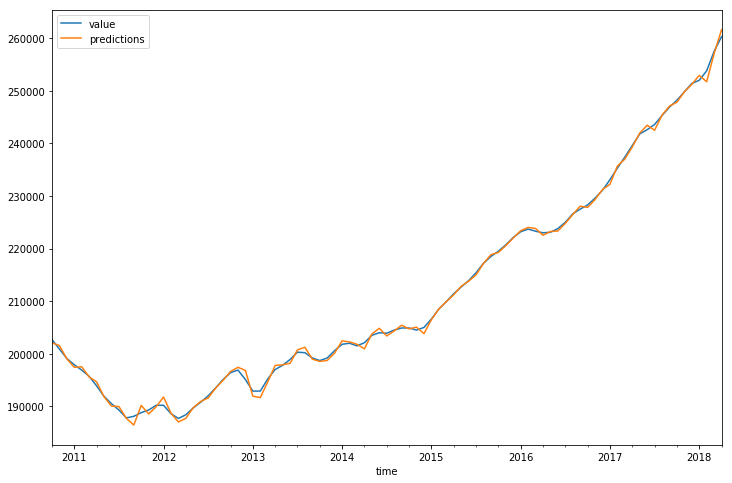

In [149]:
fruita_test.plot(figsize = (12, 8))

In [150]:
fruita_forecast_model = ARIMA(melted_fruita, order = (2,1,2))
fruita_forecast_model_fit = fruita_forecast_model.fit(disp = 0)
fruita_yhat = fruita_forecast_model_fit.forecast(steps = 36)[0]

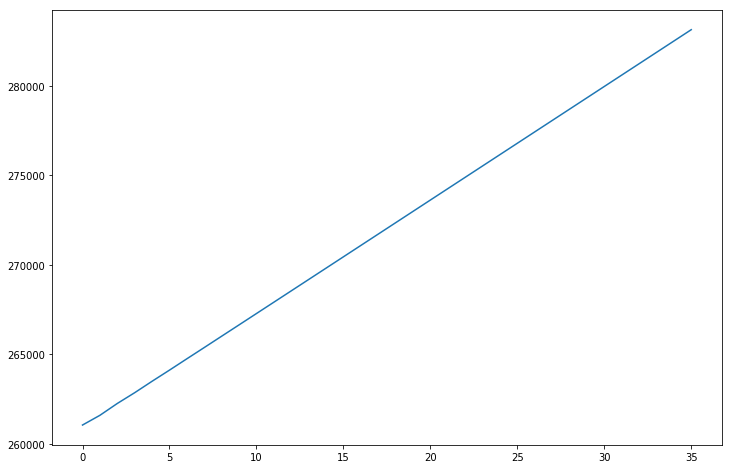

In [151]:
fig = plt.figure(figsize = (12, 8))
plt.plot(fruita_yhat)

In [152]:
len(fruita_test)

91

In [153]:
fruita_roi = (fruita_yhat[35]-fruita_test.iloc[90, 0])/fruita_test.iloc[90, 0]
fruita_roi

0.08776989265212902

#### Conclusions
There is a 8.7% increase expected over the next three years in Fruita.

### Clifton

In [154]:
arima_order(melted_clifton, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=397538282.869
ARIMA(0, 1, 0) MSE=1374353.945
ARIMA(0, 1, 1) MSE=476244.806
ARIMA(0, 2, 0) MSE=460734.105
ARIMA(0, 2, 1) MSE=354564.760
Best ARIMA(0, 2, 1) MSE=354564.760
ARIMA(1, 1, 0) MSE=436183.153
ARIMA(1, 1, 1) MSE=318108.542
ARIMA(1, 1, 2) MSE=337197.931
ARIMA(1, 2, 0) MSE=448622.737
ARIMA(1, 2, 1) MSE=357139.820
ARIMA(1, 2, 2) MSE=305221.804
Best ARIMA(1, 2, 2) MSE=305221.804
ARIMA(2, 0, 1) MSE=322271.243
ARIMA(2, 0, 2) MSE=339162.929
ARIMA(2, 1, 0) MSE=407525.019
ARIMA(2, 1, 1) MSE=323056.480
ARIMA(2, 1, 2) MSE=298579.777
ARIMA(2, 2, 0) MSE=266166.683
ARIMA(2, 2, 1) MSE=269355.881
ARIMA(2, 2, 2) MSE=286369.374
Best ARIMA(2, 2, 0) MSE=266166.683
ARIMA(4, 0, 1) MSE=263132.832
ARIMA(4, 0, 2) MSE=279894.534
ARIMA(4, 2, 0) MSE=273910.225
ARIMA(4, 2, 1) MSE=277787.792
Best ARIMA(4, 0, 1) MSE=263132.832
ARIMA(6, 0, 1) MSE=277161.766
ARIMA(6, 0, 2) MSE=252800.477
ARIMA(6, 1, 0) MSE=274613.854
ARIMA(6, 2, 0) MSE=282639.249
ARIMA(6, 2, 1) MSE=278104.321
Best ARIMA(6, 0,

In [155]:
clifton_train_size = int(len(melted_clifton)*.66)
clifton_train, clifton_test = melted_clifton[0:clifton_train_size], melted_clifton[clifton_train_size:]

In [156]:
clifton_predictions = arima_predictions(melted_clifton, (6,0,2))

In [157]:
clifton_predictions_list = []
for x in clifton_predictions:
    clifton_predictions_list.append(x[0])

In [158]:
clifton_test['predictions'] = clifton_predictions_list

In [159]:
clifton_test.head()

,value,predictions
time,,
2010-10-01,139400.0,139271.783964
2010-11-01,136600.0,136695.435404
2010-12-01,133800.0,133780.979663
2011-01-01,131700.0,130939.838815
2011-02-01,129900.0,129971.372638


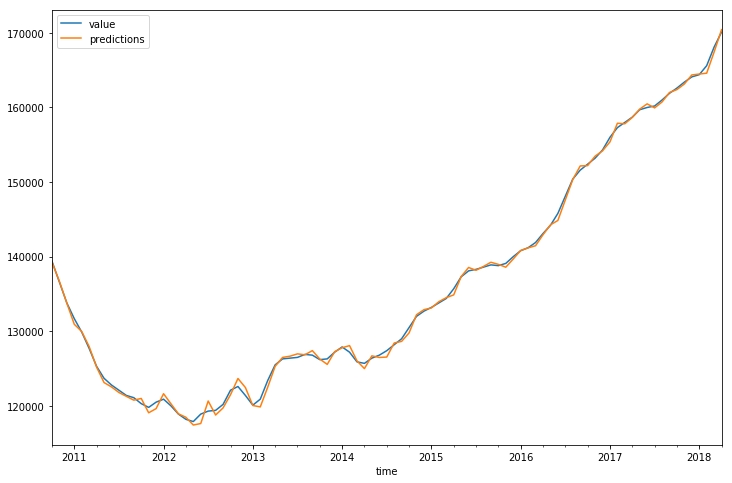

In [160]:
clifton_test.plot(figsize = (12, 8))

In [161]:
clifton_forecast_model = ARIMA(melted_clifton, order = (6,0,2))
clifton_forecast_model_fit = clifton_forecast_model.fit(disp = 0)
clifton_yhat = clifton_forecast_model_fit.forecast(steps = 36)[0]

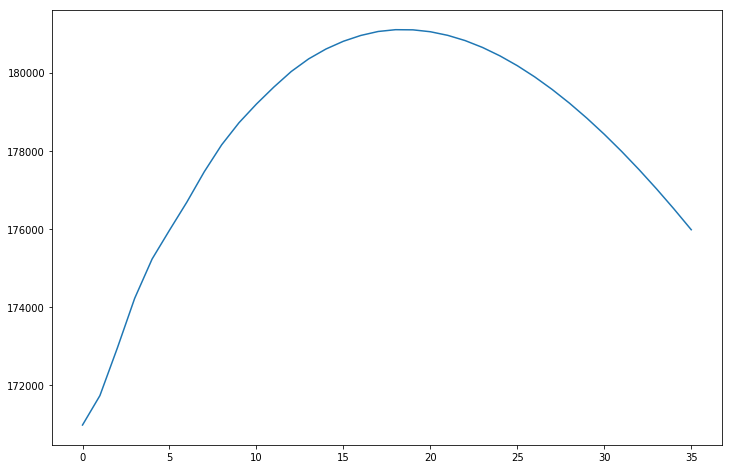

In [162]:
fig = plt.figure(figsize = (12, 8))
plt.plot(clifton_yhat)

In [163]:
len(clifton_test)

91

In [164]:
clifton_roi = (clifton_yhat[35]-clifton_test.iloc[90, 0])/clifton_test.iloc[90, 0]
clifton_roi

0.034566680219131084

### Conclusions
There is a 3.4% increase expected over the next three years in Clifton.

### Grand Junction 3 

In [165]:
arima_order(melted_grand_junction_3, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=2611757185.379
ARIMA(0, 1, 0) MSE=1898043.527
ARIMA(0, 1, 1) MSE=835488.104
ARIMA(0, 2, 0) MSE=1187348.989
ARIMA(0, 2, 1) MSE=889150.020
Best ARIMA(0, 1, 1) MSE=835488.104
ARIMA(1, 1, 0) MSE=1086840.577
ARIMA(1, 1, 1) MSE=760628.364
ARIMA(1, 1, 2) MSE=698033.645
ARIMA(1, 2, 0) MSE=1135777.483
ARIMA(1, 2, 1) MSE=904052.027
ARIMA(1, 2, 2) MSE=756885.261
Best ARIMA(1, 1, 2) MSE=698033.645
ARIMA(2, 0, 1) MSE=783236.359
ARIMA(2, 1, 0) MSE=955167.775
ARIMA(2, 1, 1) MSE=763381.165
ARIMA(2, 1, 2) MSE=644976.590
ARIMA(2, 2, 0) MSE=702304.571
ARIMA(2, 2, 1) MSE=714755.532
ARIMA(2, 2, 2) MSE=773679.293
Best ARIMA(2, 1, 2) MSE=644976.590
ARIMA(4, 0, 1) MSE=673543.473
ARIMA(4, 0, 2) MSE=713248.370
ARIMA(4, 1, 0) MSE=658388.427
ARIMA(4, 1, 1) MSE=669488.455
ARIMA(4, 1, 2) MSE=629038.110
ARIMA(4, 2, 0) MSE=716927.853
ARIMA(4, 2, 1) MSE=728750.320
Best ARIMA(4, 1, 2) MSE=629038.110
ARIMA(6, 0, 1) MSE=670930.126
ARIMA(6, 1, 0) MSE=665819.177
ARIMA(6, 1, 1) MSE=676986.292
ARIMA(6, 2, 

In [166]:
grand_junction_3_train_size = int(len(melted_grand_junction_3)*.66)
grand_junction_3_train, grand_junction_3_test = melted_grand_junction_3[0:grand_junction_3_train_size], melted_grand_junction_3[grand_junction_3_train_size:]

In [167]:
grand_junction_3_predictions = arima_predictions(melted_grand_junction_3, (4,1,2))

In [168]:
grand_junction_3_predictions_list = []
for x in grand_junction_3_predictions:
    grand_junction_3_predictions_list.append(x[0])

In [169]:
grand_junction_3_test["predictions"] = grand_junction_3_predictions_list

In [170]:
grand_junction_3_test.head()

,value,predictions
time,,
2010-10-01,216200.0,216291.074579
2010-11-01,214000.0,214171.230623
2010-12-01,212200.0,212261.969714
2011-01-01,211600.0,210416.503484
2011-02-01,211700.0,212127.006661


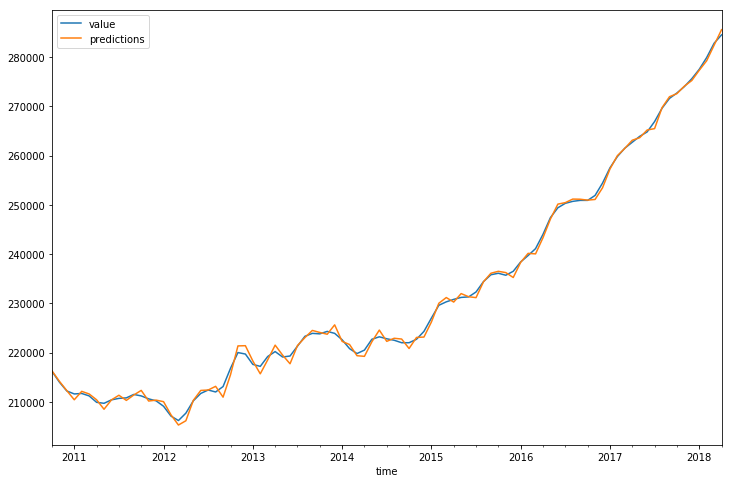

In [171]:
grand_junction_3_test.plot(figsize = (12, 8))

In [172]:
grand_junction_3_forecast_model = ARIMA(melted_grand_junction_3, order = (4,1,2))
grand_junction_3_forecast_model_fit = grand_junction_3_forecast_model.fit(disp = 0)
grand_junction_3_yhat = grand_junction_3_forecast_model_fit.forecast(steps = 36)[0]

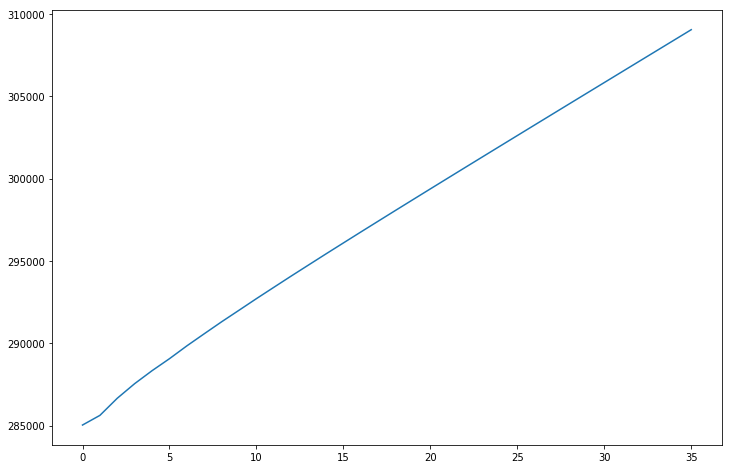

In [173]:
fig = plt.figure(figsize = (12, 8))
plt.plot(grand_junction_3_yhat)

In [174]:
len(grand_junction_3_test)

91

In [175]:
grand_junction_3_roi = (grand_junction_3_yhat[35]-grand_junction_3_test.iloc[90, 0])/grand_junction_3_test.iloc[90, 0]
grand_junction_3_roi

0.08628854830877819

In [176]:
grand_junction_3

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
7969,81505,Grand Junction,CO,Grand Junction,Mesa,111700.0,111400.0,110900.0,110300.0,109700.0,...,266900,269600,271600,272700,274000,275600,277500,279900,282800,284500


#### Conclusions
There is a 8.6% increase expected over the next three years in Grand Junction-81505.

# Step 6: Interpreting Results

First, we will use lists to make a Pandas DataFrame that contains each city name, zipcode, and calculated ROI. From there, we will use a sort method to determine the top 5 and bottom 5 zipcodes with the highest and lowest (respectively) expected ROI. 

In [177]:
roi = [aurora_roi, denver_roi, durango_roi, boulder_1_roi, boulder_2_roi, boulder_3_roi, grand_junction_1_roi,
      montrose_roi, colorado_springs_roi, cortez_roi, grand_junction_2_roi, fruita_roi, clifton_roi, grand_junction_3_roi]
city = ["Aurora", "Denver", "Durango", "Boulder-80301", "Boulder-80302", "Boulder-80303", "Grand Junction-81501", "Montrose", "Colorado Springs",
       "Cortez", "Grand Junction-81507", "Fruita", "Clifton", "Grand Junction-81505"]
zipcode = [80011, 80206, 81301, 80301, 80302, 80303, 81501, 81401, 80903, 81321, 81507, 81521, 81520, 81505]

In [178]:
roi_df = pd.DataFrame({"City Name":city, "Zipcode":zipcode, "ROI": roi})

In [179]:
roi_df.sort_values("ROI", ascending = False)

,City Name,Zipcode,ROI
0,Aurora,80011,0.358108
1,Denver,80206,0.163355
10,Grand Junction-81507,81507,0.140003
4,Boulder-80302,80302,0.131190
5,Boulder-80303,80303,0.112245
8,Colorado Springs,80903,0.101281
11,Fruita,81521,0.087770
13,Grand Junction-81505,81505,0.086289
3,Boulder-80301,80301,0.085253
2,Durango,81301,0.065274


# Conclusion: 

Of the 14 zipcodes studied, the 5 zipcodes in Colorado that would yield the highest return on investment are 
* 80011 Aurora at 35.8%
* 80206 Denver Metro at 16.3%
* 81507 Grand Junction at 14.0%
* 80302 Boulder at 13.1%
* 80303 Boulder at 11.2%

The bottom 5 zipcodes that would yield the lowest ROI are
* 81401 Montrose at -6.2%
* 81520 Clifton at 3.4% 
* 81501 Grand Junction at 3.8%
* 81321 Cortez at 4.3% 
* 81301 Durango at 6.5%